In [38]:
from numpy import *
from scipy.optimize import fsolve
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

The gas phase reaction:
$$ A \rightarrow 2B $$
occurs in a shell and tube packed bed reactor where pure $A$ at $2~bar$ and $150~°C$ is fed at $400~kmol/hr$. The reactor has $200$ tubes and the shell has a cooling medium at a constant temperature of $25~°C$. Determine the diameter and length of the tubes so that the reaction temperature never exceeds $200~°C$. You need to have a conversion higher than $96~\%$. You can use the following expression for the pressure drop:
$$ \dfrac{dP}{dz} = -K_{Ergun}\dfrac{F_{T}}{F_{T_{0}}}\dfrac{P_{0}}{P}\dfrac{T}{T_{0}} $$

Information for this system:

<img src="2.3a.PNG" width="350" />

(assume hat tubes are available in diameters $25$, $28$, and $30~mm$. Remember that $K_{Ergun} \propto G^{2}$ in turbulent flow and it will therefore also depend on the tube diameter.)

<img src="2.3b.PNG" width="850" />

In [39]:
#Gas phase
#Pure A fed
Ntubes =        200
koprm  =        700 #m3/kg.s #therefore 1st order rx
Ea     =      40000 #J/mol
CpA    =        500 #J/(mol.K)
CpB    =    0.5*CpA
dHrx   =     -47500 #J/mol
U      =        200 #W/(m2.K)
rhobed =        800 #kg/m3
W      =        700 #kg
Wpt    =   W/Ntubes
Kerg30i= 0.02e3*100 #kPa/m (pressure drop constant for 30mm tubes)
D30    =      0.030 #m tube diameter
D28    =      0.028 #m tube diameter
D25    =      0.025 #m tube diameter
Po     =    2e3*100 #kPa
To     = 150+273.15 #K
T      = 200+273.15 #K
Tu     =  25+273.15 #K
FAo    = 400e3/3600 #mol/s
FAopt  = FAo/Ntubes #mol/s/tube
R      =      8.314 #kJ/Kmol/K
Qo     = FAopt*R*To/Po

In [40]:
Wpt

3.5

In [41]:
D = array([D25, D28, D30])
D

array([0.025, 0.028, 0.03 ])

In [42]:
Ax = 0.25*pi*D**2
Ax

array([0.00049087, 0.00061575, 0.00070686])

In [43]:
Ax30 = 0.25*pi*D30**2
Ax28 = 0.25*pi*D28**2
Ax25 = 0.25*pi*D25**2

For Turbulent flow assumed as given in the description:
\begin{equation}
			\frac{dP}{dz} = -\dfrac{1.75G^{2}}{\rho_{\circ}d_{p}}\left(\frac{1 - \epsilon}{\epsilon}\right)\left(\dfrac{P_{\circ}}{P}\frac{F_{T}}{F_{T_{\circ}}}\frac{T}{T_{\circ}}\right)
\end{equation}

But $K_{Ergun}$ units are in $\dfrac{Pressure}{m}$, therefore:

From $ \dfrac{dP}{dz} $, $ dz = \dfrac{dW}{\rho_{B}*A_{across}} $

Where $ A_{across} = \pi\frac{D_{tube}^{2}}{4}$ therefore substituting $dz$ into equation above in terms of $\frac{dP}{dW}:  $

$$
\begin{equation}
		\frac{dP}{dW} = -\dfrac{1.75}{\rho_{\circ}d_{p}}\left(\frac{1 - \epsilon}{\epsilon}\right)\dfrac{G^{2}}{\rho_{B}A_{across}}\left(\dfrac{P_{\circ}}{P}\frac{F_{T}}{F_{T_{\circ}}}\frac{T}{T_{\circ}}\right)
\end{equation}
$$	
Where:
$$
\begin{equation}
		K_{Ergun}^{'} = -\dfrac{1.75}{\rho_{\circ}d_{p}}\left(\frac{1 - \epsilon}{\epsilon}\right)\dfrac{G^{2}}{\rho_{B}A_{across}}
\end{equation}
$$

$K_{Ergun}'$ units are in $\dfrac{Pressure}{kg}$, so:

\begin{align}
			 K_{Ergun}'  &\propto \dfrac{G^{2}}{\rho_{B}A_{across}} \nonumber\\
			  &\propto \dfrac{\dot{m^{2}}/A_{across}^{2}}{\rho_{B}A_{across}} \nonumber \\
			  &\propto \dfrac{\dot{m^{2}}}{\rho_{B}A_{across}^{3}} \nonumber \\
			 K_{Ergun}'  &\propto \dfrac{\dot{m^{2}}}{\rho_{B}D_{Tube}^{6}} \nonumber \nonumber 
		\end{align}

Therefore, after prorating:
\begin{align}
K_{Ergun2}^{'} &= \left(\dfrac{D_{1}}{D_{2}}\right)^{6}K_{Ergun1}^{'} \nonumber
\end{align}

In [44]:
Kerg30 = Kerg30i/(rhobed*Ax30)
Kerg30 #kPa/kg

3536.7765131532296

In [45]:
Kerg28 = ((30/28)**6)*Kerg30
Kerg25 = ((30/25)**6)*Kerg30

In [46]:
Kerg = array([Kerg25, Kerg28, Kerg30])
Kerg

array([10560.75807985,  5350.40870648,  3536.77651315])

In [47]:
Kerg28i = Kerg28*rhobed*Ax28
Kerg25i = Kerg25*rhobed*Ax25

Rate equations:
\begin{align}
r_{A}^{'} &= -k_{0}^{'}e^{-\dfrac{E_{a}}{RT}}C_{A_{0}}(1 - X) \nonumber \\
r_{B}^{'} &= -2r_{A}^{'} \nonumber
\end{align} 

Algebraic equations:
\begin{align}
F_{A} &= F_{A_{0}}(1 - X_{A}) \\
F_{B} &= \dfrac{1}{2}F_{A_{0}}X_{A} \\
F_{T} &= F_{A} + F_{B} \\
Q &= \dfrac{F_{T}RT}{P} 
\end{align}

Mole balance:
\begin{align}
\dfrac{dF_{A}}{dW} &= r_{A}^{'} \nonumber \\
-F_{A_{0}}\dfrac{dX}{dW} &= -k_{0}^{'}e^{-\dfrac{E_{a}}{RT}}C_{A_{0}}(1 - X)  \nonumber \\
Q_{0}C_{A_{0}}\dfrac{dX}{dW} &= k_{0}^{'}e^{-\dfrac{E_{a}}{RT}}C_{A_{0}}(1 - X)  \nonumber \\
\dfrac{dX}{dW} &= \dfrac{k_{0}^{'}}{Q_{0}}e^{-\dfrac{E_{a}}{RT}}(1 - X)  \nonumber \\
\end{align}

The energy balance for a non-adiabatic, non-isothermal PBR:
$$
\begin{align}
\dfrac{\Delta\Sigma (H_{i})}{\Delta W} &= U(T_{U} - T)\dfrac{\Delta A}{\Delta W} \nonumber
\end{align}
$$
But 
$$
\begin{align}
\dfrac{\Delta A}{\Delta W} &= \dfrac{\pi.D\Delta z}{\Delta W} \nonumber \\
&= \dfrac{\pi.D}{\Delta W}.\dfrac{\Delta W}{\rho_{bed}A_{across}} \nonumber \\
&= \dfrac{4\pi.D}{\rho_{bed}\pi D^{2}} \nonumber \\
a &= \dfrac{4}{\rho_{bed}D} \nonumber 
\end{align}
$$
therefore 
$$
\begin{align}
\dfrac{\Delta\Sigma (H_{i})}{\Delta W} &= U(T_{U} - T).a \nonumber
\end{align}
$$

Energy balance over a slice:
$$
\begin{align}
\dfrac{d\Sigma (H_{i})}{\Delta W} &=  Ua(T_{U} - T) \nonumber \\
&= \dfrac{\Sigma F_{i}C_{p_{i}}dT}{dW} + \Delta H_{RX_{j}}\dfrac{d\epsilon_{i}}{dW} \nonumber
\end{align}
$$
where
$$
\begin{align}
d\epsilon_{i} &= \dfrac{dF_{A_{j}}}{\nu_{A_{j}}} \nonumber \\
&= -dF_{A_{j}}
\end{align}
$$
Therefore
$$
\begin{align}
\dfrac{d\Sigma (H_{i})}{\Delta W} &= \dfrac{\Sigma F_{i}C_{p_{i}}dT}{dW} - \Delta H_{RX(T)}\dfrac{dF_{A_{j}}}{dW} \nonumber \\
Ua(T_{U} - T) &= \dfrac{\Sigma F_{i}C_{p_{i}}dT}{dW} - \Delta H_{RX(T)}r_{A_{j}}^{'} \nonumber \\
\dfrac{dT}{dW} &= \dfrac{Ua(T_{U} - T) + r_{A_{j} \Delta H_{RX(T)}}}{\Sigma F_{i_{0}}C_{p_{i_{0}}}} \nonumber 
\end{align}
$$

Pressure Drop equation:

\begin{equation}
		\frac{dP}{dW} = -K_{Ergun}^{'}\left(\dfrac{P_{\circ}}{P}\frac{F_{T}}{F_{T_{\circ}}}\frac{T}{T_{\circ}}\right)
\end{equation}

In [48]:
Dspan = linspace(D25,D30,500)
#Conversion = Drange(Dspan)
Conversion = []
Length     = []
Temperature= []
Tmax       = []
Pout       = []
for vals in Dspan:
    D = vals
    
    def PBR(var,w):
        FA, FB, T, P = var
        Ftot   = FA + FB
        a      = 4/(rhobed*D)
        kprm   = koprm*exp(-Ea/(R*T))
        Q      = Ftot*R*T/P
        rAprm  = -kprm*(FA/Q)
        rBprm  = -2*rAprm
        dFAdW  = rAprm
        dFBdW  = rBprm        
        M      = U*a*(Tu - T)/(FAopt*CpA)
        C      = rAprm*dHrx/(FAopt*CpA)
        dTdW   = M + C
        Kerg   = ((D30/D)**6)*Kerg30
        dPdW   = -Kerg*(Po/P)*(Ftot/FAopt)*(T/To) #sign?
        #print(w)
        return[dFAdW,dFBdW,dTdW,dPdW]
        
    W     = Wpt #kg
    wspan = linspace(0,W,36)
    init  = (FAopt, 0, To, Po)
    sols  = odeint(PBR,init,wspan)
    
    FA,FB,T,P = sols.T
    Tmx       = max(T)
    XA = (FAopt - FA[-1])/FAopt
    Ax = 0.25*pi*D**2
    L  = W/(rhobed*Ax)
    Conversion.append(XA)
    Length.append(L)
    Temperature.append(T[-1]) #this is temperature out
    Tmax.append(Tmx)
    Pout.append(P[-1])
Wpt

3.5

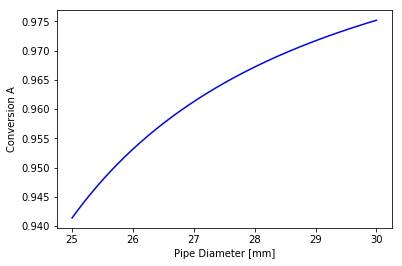

In [49]:
plt.figure(1)
plt.plot(Dspan*1000, Conversion, color='blue', label='XA')
plt.ylabel('Conversion A') 
plt.xlabel('Pipe Diameter [mm]') 
plt.show()

In [55]:
Conv28 = interp(-0.028,-Dspan[::-1], Conversion[::-1])
Conv28

0.9671927150658357

In [51]:
Tmax28 = interp(-0.028, -Dspan[::-1],Tmax[::-1])
Tmax28-273.15

197.26558728726167

In [52]:
P28 = interp(-0.028, -Dspan[::-1],Pout[::-1])
P28/1000/100

1.6092053475681656

In [53]:
L = Wpt/(Ax28*rhobed)
L

7.10513138803104

In [54]:
Conv30 = interp(-0.030,-Dspan[::-1], Conversion[::-1])
Conv30

0.9751796168732